In [1]:
import numpy as np

# Load the data
X = np.load('archive-2/Sign-language-digits-dataset/X.npy')

# flatten the X matrix
X = X.reshape(X.shape[0], -1)

Y = np.zeros((X.shape[0], 10))
Y[0:204, 9] = 1
Y[204:409, 0] = 1
Y[409:615, 7] = 1
Y[615:822, 6] = 1
Y[822:1028, 1] = 1
Y[1028:1236, 8] = 1
Y[1236:1443, 4] = 1
Y[1443:1649, 3] = 1
Y[1649:1855, 2] = 1
Y[1855:, 5] = 1

indices = np.argmax(Y, axis=1)
Y = np.expand_dims(indices, axis=1)

In [2]:
# Split data into train and test

import numpy as np
from tensorflow.keras.utils import to_categorical

data = np.concatenate((Y, X), axis=1)

np.random.shuffle(data)

# Extract features (pixel values) and labels
X = data[:, 1:]  # Pixel values
y = data[:, 0]   # Labels

# Convert labels to one-hot encoding
y_one_hot = to_categorical(y, num_classes=10)  # Assuming you have 10 classes (digits 0 to 9)

# Now, 'X' contains the pixel values, and 'y_one_hot' contains the one-hot encoded labels

# from sklearn.decomposition import PCA

# pca = PCA(n_components=2025)
# X = pca.fit_transform(X)

# Split the data into training, validation and testing sets (you may need to adjust the split ratio)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size=0.1, random_state=42)

X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.3, random_state=42)

# Now, you can use X_train and y_train to train your neural network, and X_test and y_test for testing.

2023-11-08 18:11:34.693836: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


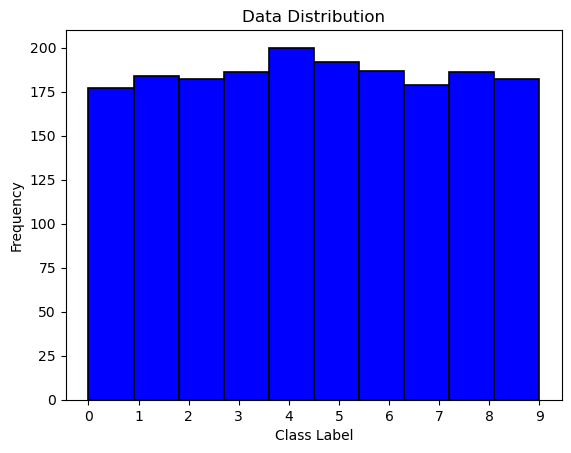

In [3]:
# plot the data distribution in a histogram where each column represents a class label with different color.
import matplotlib.pyplot as plt

y_train_count = np.argmax(y_train, axis=1)
plt.hist(y_train_count, bins=10, color='blue', edgecolor='black', linewidth=1.2)
plt.title("Data Distribution")
plt.xlabel("Class Label")
plt.ylabel("Frequency")
plt.xticks(range(0, 10))
plt.show()

In [4]:
import cv2
import numpy as np

def augment_data(images, labels, num_augmented_samples=1):
    augmented_images = []
    augmented_labels = []
    
    center = (32, 32)
    scale = 1.0

    for i in range(len(images)):
        image = images[i]
        label = labels[i]

        for _ in range(num_augmented_samples):
            augmented_image = image.reshape(64, 64)              

            # Randomly rotate the image (between -10 and 10 degrees)
            angle = np.random.randint(-10, 10)
            M = cv2.getRotationMatrix2D(center, angle, scale)
            augmented_image = cv2.warpAffine(augmented_image, M, (64, 64))

            # crop the image so that it is 50x50 pixels in size and then back to 64x64
            augmented_image = augmented_image[7:57, 7:57]
            augmented_image = cv2.resize(augmented_image, (64, 64))

            augmented_images.append(augmented_image)
            augmented_labels.append(label)

    return np.array(augmented_images), np.array(augmented_labels)


X_aumented, y_aumented = augment_data(X_train, y_train, num_augmented_samples=3)
X_aumented = X_aumented.reshape(X_aumented.shape[0], -1)
X_train = np.concatenate((X_train, X_aumented), axis=0)
y_train = np.concatenate((y_train, y_aumented), axis=0)

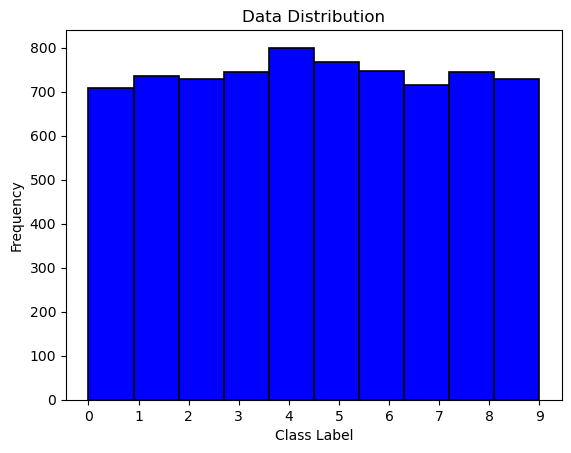

In [5]:
# plot the data distribution in a histogram where each column represents a class label with different color.
import matplotlib.pyplot as plt

y_train_count = np.argmax(y_train, axis=1)

plt.hist(y_train_count, bins=10, color='blue', edgecolor='black', linewidth=1.2)
plt.title("Data Distribution")
plt.xlabel("Class Label")
plt.ylabel("Frequency")
plt.xticks(range(0, 10))
plt.show()

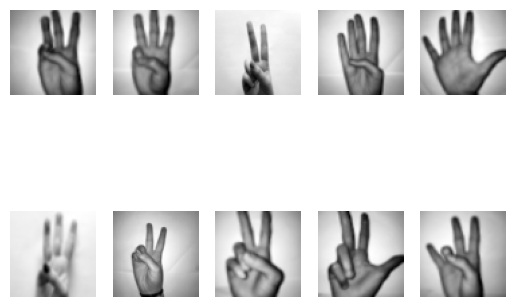

In [6]:
# plot teh first augmented image
import matplotlib.pyplot as plt
import random

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(X_train[random.randint(0, len(X_train))].reshape(64, 64), cmap='gray')
    plt.axis('off')

plt.show()

In [7]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.regularizers import l2

# Function to build a simple CNN model
def build_cnn_model(input_shape, num_classes):
    model = tf.keras.Sequential()
    
    # Convolutional and pooling layers
    model.add(tf.keras.layers.Conv2D(32, (7, 7), activation='relu', input_shape=input_shape))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.Conv2D(64, (7, 7), activation='relu', input_shape=input_shape))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    
    # Flatten the output before fully connected layers
    model.add(tf.keras.layers.Flatten())
    
    # Fully connected layers
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.Dense(32, activation='relu'))
    model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))
    
    return model

def build_cnn_model_with_regularization(input_shape, num_classes, l2_strength=0.01, dropout_rate=0.5):
    model = Sequential()
    
    # Convolutional and pooling layers with L2 regularization
    model.add(Conv2D(32, (7, 7), activation='relu', input_shape=input_shape, kernel_regularizer=l2(l2_strength)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (7, 7), activation='relu', kernel_regularizer=l2(l2_strength)))
    model.add(MaxPooling2D((2, 2)))
    
    # Flatten the output before fully connected layers
    model.add(Flatten())
    
    # Fully connected layers with L2 regularization and Dropout
    model.add(Dense(128, activation='relu', kernel_regularizer=l2(l2_strength)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(64, activation='relu', kernel_regularizer=l2(l2_strength)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(32, activation='relu', kernel_regularizer=l2(l2_strength)))
    
    # Output layer
    model.add(Dense(num_classes, activation='softmax'))
    
    return model


# Example usage
input_shape = (64, 64, 1)  # Adjust the input shape to match your image size and channels
num_classes = 10  # Number of output classes

# Create the CNN model
cnn_model = build_cnn_model(input_shape, num_classes)

# Compile the model with an appropriate optimizer and loss function
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
cnn_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

optimizer_reg = tf.keras.optimizers.Adam(learning_rate=0.001)
cnn_model_regularized = build_cnn_model_with_regularization(input_shape, num_classes, l2_strength=0.01, dropout_rate=0.01)
cnn_model_regularized.compile(optimizer=optimizer_reg, loss='categorical_crossentropy', metrics=['accuracy'])

2023-11-08 18:11:37.279243: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [8]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

X_train = X_train.reshape(X_train.shape[0], 64, 64, 1)
X_val = X_val.reshape(X_val.shape[0], 64, 64, 1)
X_test = X_test.reshape(X_test.shape[0], 64, 64, 1)

early_stoping = EarlyStopping(monitor='val_loss', 
                              min_delta=0.001,
                              patience= 5,
                              restore_best_weights= True, 
                              verbose = 0)

reduce_learning_rate = ReduceLROnPlateau(monitor='val_accuracy', 
                                         patience = 2, 
                                         factor=0.5 , 
                                         verbose = 1)

# Train the model
history = cnn_model.fit(X_train, y_train, batch_size=10, epochs=40, validation_data=(X_val, y_val), callbacks=[early_stoping, reduce_learning_rate])    


# After training, you can evaluate the model on the test data
test_loss, test_accuracy = cnn_model.evaluate(X_test, y_test)


# Print the test accuracy
print(f'Test Accuracy: {test_accuracy}')


Epoch 1/40
742/742 [==============================] - 62s 82ms/step - loss: 0.9407 - accuracy: 0.6705 - val_loss: 0.3196 - val_accuracy: 0.9206 - lr: 0.0010
Epoch 2/40
742/742 [==============================] - 62s 83ms/step - loss: 0.1892 - accuracy: 0.9383 - val_loss: 0.1968 - val_accuracy: 0.9524 - lr: 0.0010
Epoch 3/40
742/742 [==============================] - 64s 86ms/step - loss: 0.0909 - accuracy: 0.9704 - val_loss: 0.3254 - val_accuracy: 0.8413 - lr: 0.0010
Epoch 4/40
742/742 [==============================] - ETA: 0s - loss: 0.0587 - accuracy: 0.9814
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
742/742 [==============================] - 56s 76ms/step - loss: 0.0587 - accuracy: 0.9814 - val_loss: 0.1051 - val_accuracy: 0.9524 - lr: 0.0010
Epoch 5/40
742/742 [==============================] - 59s 80ms/step - loss: 0.0100 - accuracy: 0.9980 - val_loss: 0.1163 - val_accuracy: 0.9683 - lr: 5.0000e-04
Epoch 6/40
742/742 [==============================

In [9]:
# Function to visualize feature maps
def visualize_feature_maps(model, layer_name, input_image):
    # Extract intermediate layers
    intermediate_layer_model = tf.keras.models.Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
    
    # Get the activations of the layer for the given input image
    activations = intermediate_layer_model.predict(input_image.reshape(1, 64, 64, 1))
    
    num_images_per_row = 8
    num_features = activations.shape[-1]
    num_rows = (num_features - 1) // num_images_per_row + 1
    
    p = plt.figure(figsize=(15, 2 * num_rows))
    for i in range(num_features):
        plt.subplot(num_rows, num_images_per_row, i + 1)
        plt.imshow(activations[0, :, :, i], cmap='viridis')
        plt.axis('off')
    plt.show()
    # save the image
    p.savefig('feature_map.png')

In [18]:
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 58, 58, 32)        1600      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 29, 29, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 23, 23, 64)        100416    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 11, 11, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 7744)              0         
                                                                 
 dense (Dense)               (None, 128)               9

1/1 [==============================] - 0s 32ms/step


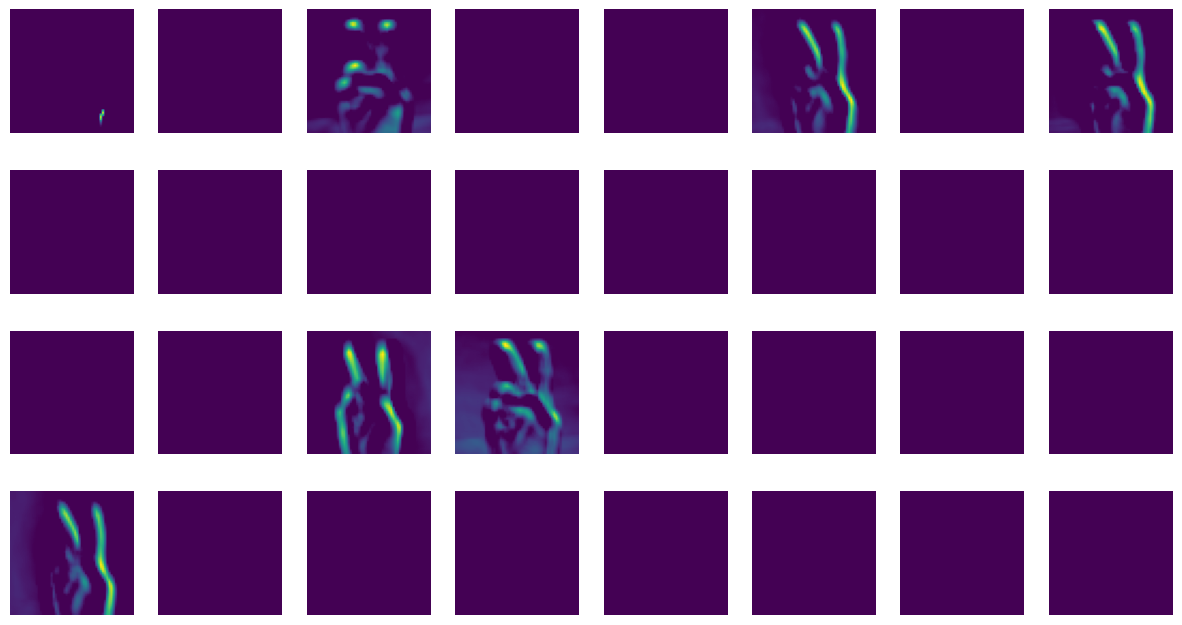

1/1 [==============================] - 0s 33ms/step


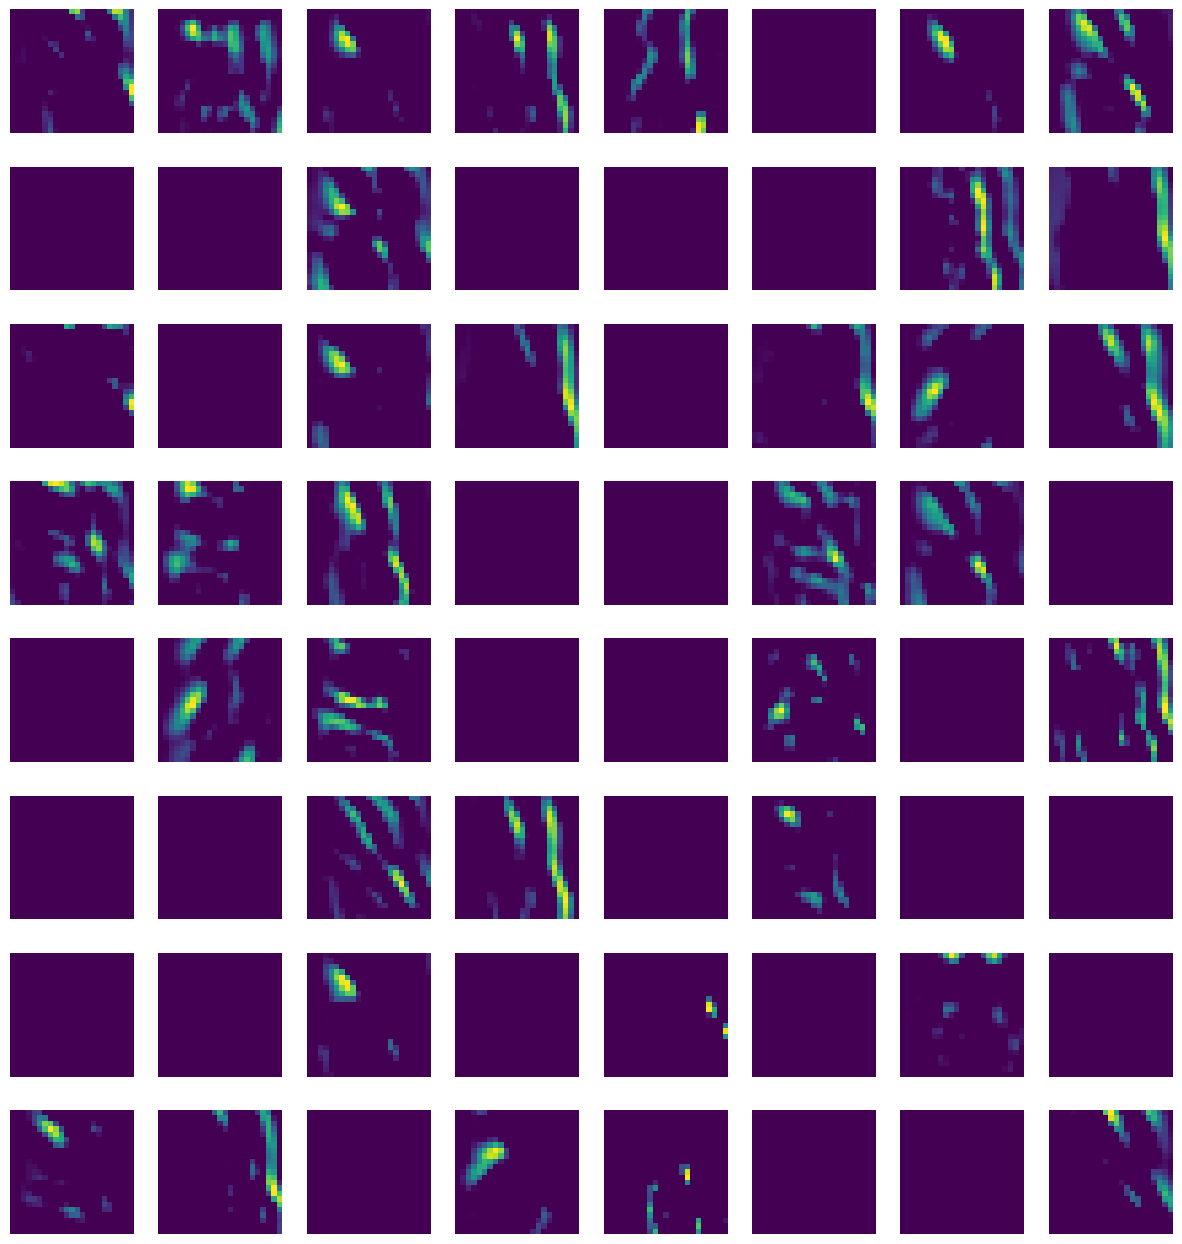

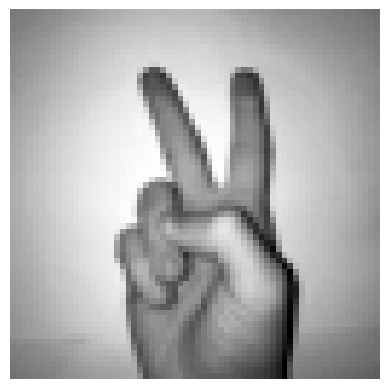

In [21]:
# Visualize feature maps for a specific layer
layer_name = 'conv2d'  # Change to the layer name you want to visualize
layer_name1 = 'conv2d_1'  # Change to the layer name you want to visualize
input_image = X_train[5]  # Example input image
visualize_feature_maps(cnn_model, layer_name, input_image)
visualize_feature_maps(cnn_model, layer_name1, input_image)

# plot the original image
import matplotlib.pyplot as plt

plt.imshow(X_train[5].reshape(64, 64), cmap='gray')
plt.axis('off')
plt.show()


In [11]:
early_stoping_reg = EarlyStopping(monitor='val_loss', 
                              min_delta=0.001,
                              patience= 5,
                              restore_best_weights= True, 
                              verbose = 0)

reduce_learning_rate_reg = ReduceLROnPlateau(monitor='val_accuracy', 
                                         patience = 2, 
                                         factor=0.5 , 
                                         verbose = 1)

history_reg = cnn_model_regularized.fit(X_train, y_train, batch_size=10, epochs=40, validation_data=(X_val, y_val), callbacks=[early_stoping_reg, reduce_learning_rate_reg])

test_loss_reg, test_accuracy_reg = cnn_model_regularized.evaluate(X_test, y_test)

print(f'Test Accuracy: {test_accuracy_reg}')

Epoch 1/40
742/742 [==============================] - 65s 87ms/step - loss: 2.5110 - accuracy: 0.1018 - val_loss: 2.3077 - val_accuracy: 0.0476 - lr: 0.0010
Epoch 2/40
742/742 [==============================] - 57s 77ms/step - loss: 2.3031 - accuracy: 0.1078 - val_loss: 2.3068 - val_accuracy: 0.0476 - lr: 0.0010
Epoch 3/40
742/742 [==============================] - ETA: 0s - loss: 2.3025 - accuracy: 0.1075
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
742/742 [==============================] - 57s 77ms/step - loss: 2.3025 - accuracy: 0.1075 - val_loss: 2.3081 - val_accuracy: 0.0476 - lr: 0.0010
Epoch 4/40
742/742 [==============================] - 60s 81ms/step - loss: 2.3023 - accuracy: 0.1078 - val_loss: 2.3083 - val_accuracy: 0.0476 - lr: 5.0000e-04
Epoch 5/40
742/742 [==============================] - ETA: 0s - loss: 2.3022 - accuracy: 0.1078
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
742/742 [==========================

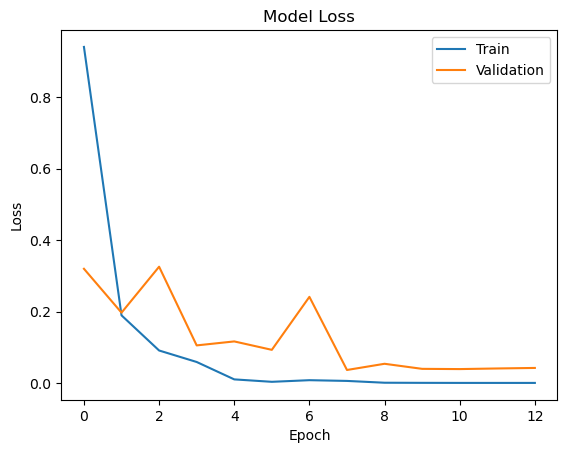

In [12]:
# plot the loss over epochs
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

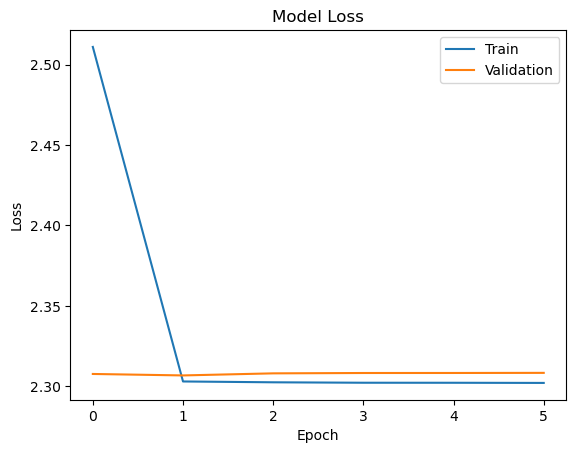

In [13]:
# plot the loss_reg over epochs
import matplotlib.pyplot as plt

plt.plot(history_reg.history['loss'])
plt.plot(history_reg.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

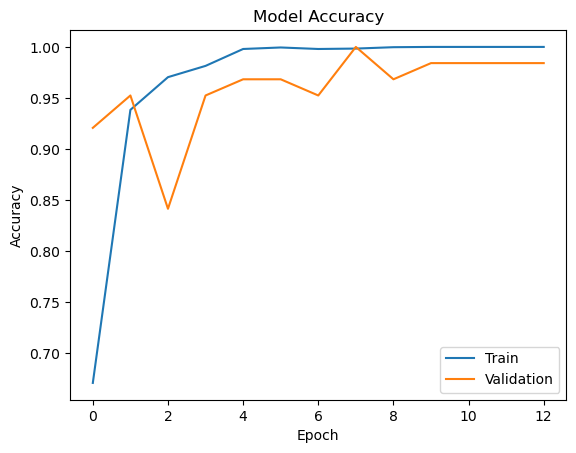

In [14]:
# plot the accuracy over epochs
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

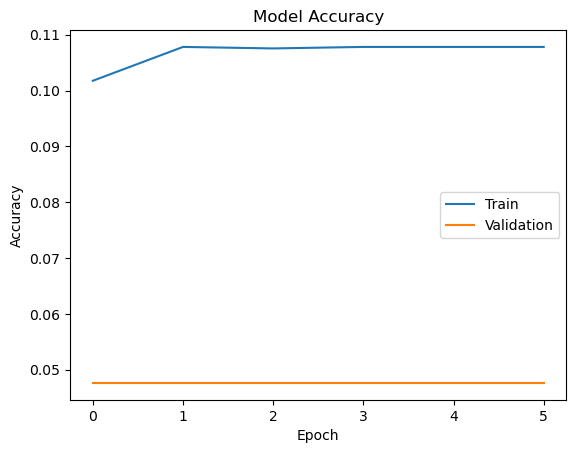

In [15]:
# plot the accuracy_reg over epochs
import matplotlib.pyplot as plt

plt.plot(history_reg.history['accuracy'])
plt.plot(history_reg.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

1/1 [==============================] - 0s 63ms/step


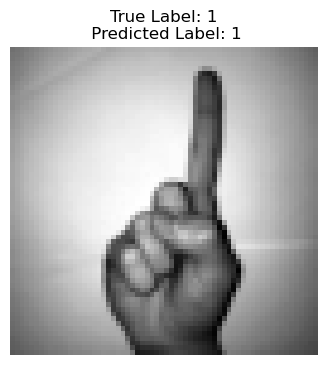

In [16]:
import numpy as np
import matplotlib.pyplot as plt

def plot_random_image_and_predict(model, X, y, class_labels):
    # Select a random index from the training set
    random_index = np.random.randint(0, len(X))
    
    # Get the image and true label
    random_image = X[random_index]
    true_label = y[random_index]
    
    # Reshape the image if it's flattened
    if random_image.shape != (64, 64):
        random_image = random_image.reshape(64, 64)
    
    # Make a prediction using the model
    # predicted = model.predict(random_image.reshape(1, -1))
    predicted = model.predict(random_image.reshape(1, 64, 64, 1))
    predicted_label = np.argmax(predicted)
    
    # Plot the image
    plt.figure(figsize=(4, 4))
    plt.imshow(random_image, cmap='gray')
    plt.title(f"True Label: {class_labels[np.argmax(true_label)]}\n Predicted Label: {class_labels[predicted_label]}")
    plt.axis('off')
    plt.show()

# Assuming you have a list of class labels
class_labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

# Call the function to display a random image and make a prediction
plot_random_image_and_predict(cnn_model, X_test, y_test, class_labels)


5/5 [==============================] - 0s 70ms/step


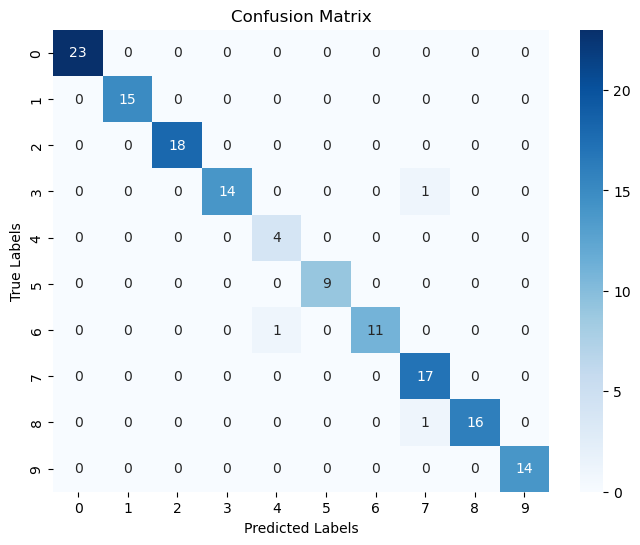

5/5 [==============================] - 0s 27ms/step


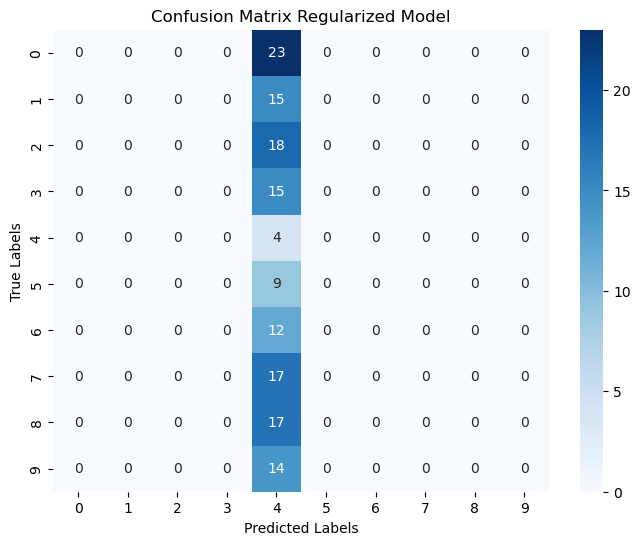

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

test_pred = cnn_model.predict(X_test)
test_pred = np.argmax(test_pred, axis=1)
y_test = np.argmax(y_test, axis=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, test_pred)
class_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# plot the confusion matrix for the regularized model
test_pred_reg = cnn_model_regularized.predict(X_test)
test_pred_reg = np.argmax(test_pred_reg, axis=1)
# y_test = np.argmax(y_test, axis=1)

# Calculate confusion matrix
conf_matrix_reg = confusion_matrix(y_test, test_pred_reg)
class_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_reg, annot=True, fmt='g', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Regularized Model')
plt.show()
